In [1]:
#!git clone https://github.com/sobrad956/CMSC472FinalProject.git

Cloning into 'CMSC472FinalProject'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 23 (delta 10), reused 17 (delta 8), pack-reused 0
Unpacking objects: 100% (23/23), 6.18 KiB | 791.00 KiB/s, done.


In [2]:
#!cd CMSC472FinalProject/

In [3]:
import torch
import torchvision as tv
import torch.random
import os
import sys
from PIL import Image
from torchvision import transforms
from torchvision.datasets import Food101
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt 
import matplotlib

In [4]:
# assumes original color temp maxed out at (255,255,255)
# expect Tensor of [..., 3 (r,g,b), H, W]
class RandomSaltPepper(torch.nn.Module):
    def __init__(self, p=0.5, type='salt'):
        super().__init__()
        self.p = p
        self.salt = type in ['salt', 'both']
        self.pepper = type in ['pepper', 'both']
        self.color = []
        if self.salt:
            self.color.append(1)
        if self.pepper:
            self.color.append(0)
    
    def forward(self, imgs):
        if not len(self.color):
            return imgs
                    
        # probably slow AF and not pythonic
        for i, img in enumerate(imgs):
            for h, row in enumerate(img[0]):
                for w, _ in enumerate(row):
                    if torch.rand(1) < self.p:
                        imgs[i,:,h,w] = self.color[torch.randint(0, len(self.color), (1,)).item()]
        
        return imgs

class RandomGaussianNoise(torch.nn.Module):
    def __init__(self, mean=0, var=1):
        super().__init__()
        self.mean = mean
        self.var = var
        self.sigma = var ** 0.5
        
    def forward(self, imgs):
        noise = torch.normal(self.mean, self.sigma, imgs.shape)
        imgs += noise
        imgs = torch.clamp(imgs, 0, 1)
        return imgs


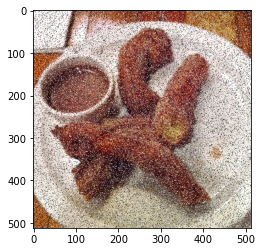

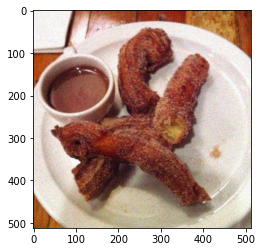

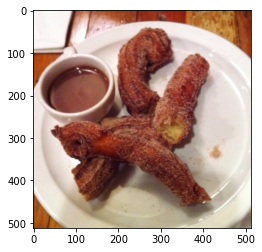

In [5]:
# simple testbench
if __name__ == '__main__':
    root = os.path.expanduser(os.path.join('', 'data'))
    dataset = Food101(root=root, download=False, transform=ToTensor())
    aug = RandomSaltPepper(p=0.2, type='both')
    aug2 = RandomGaussianNoise(mean=0,var=1./255.)
    oim = torch.unsqueeze(dataset[0][0], 0)
    aim = aug(torch.clone(oim))
    aim2 = aug2(torch.clone(oim))
    plt.figure(0)
    plt.imshow(aim[0].permute(1,2,0))
    plt.figure(1)
    plt.imshow(aim2[0].permute(1,2,0))
    plt.figure(2)
    plt.imshow(oim[0].permute(1,2,0))
    plt.show()

In [6]:
len(dataset)

75750

In [7]:
# Create Dataloaders
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


normMean = [0.49139968, 0.48215827, 0.44653124]
normStd = [0.24703233, 0.24348505, 0.26158768]
normTransform = transforms.Normalize(normMean, normStd)


trainTransform = transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normTransform
    ])
  
testTransform = transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor(),
        normTransform
    ])
  
trainLoader = DataLoader(Food101(root=root, split="train", download=False, transform=trainTransform), batch_size = 64, shuffle=True)
valLoader = DataLoader(Food101(root=root, split="test", download=False, transform=testTransform), batch_size = 64, shuffle=False)

In [8]:
#Run Densenet
#import models

from models import RunNet

r = RunNet(model='DenseNet', trainLoader=trainLoader, valLoader=valLoader, verbose=True, experiment='baseline', nEpochs = 2)
r.run()

  + Number of params: 800375


C:\Users\Ian Y\Downloads\CMSC472FinalProject\models.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(self.fc(out))


Train Epoch: 1.00, loss: 4.15, Error: 92.36, F1-Score: 0.06 


C:\Users\Ian Y\Downloads\CMSC472FinalProject\models.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(self.fc(out))



Val set Epoch: 1.00, loss: 3.88, Error: 89.36, F1-Score: 0.08


C:\Users\Ian Y\Downloads\CMSC472FinalProject\models.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(self.fc(out))


Train Epoch: 2.00, loss: 3.55, Error: 83.50, F1-Score: 0.15 


C:\Users\Ian Y\Downloads\CMSC472FinalProject\models.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(self.fc(out))



Val set Epoch: 2.00, loss: 3.61, Error: 84.36, F1-Score: 0.14


In [7]:
#Run SqueezeNet
#import squeezenet

from models import RunNet

r = RunNet(model='SqueezeNet', trainLoader=trainLoader, valLoader=valLoader, verbose=True, experiment='baseline')
r.run()

  + Number of params: 781669


KeyboardInterrupt: 

In [8]:
#Run InceptionNet3
#import inceptionnet

from models import RunNet

r = RunNet(model='InceptionNet', trainLoader=trainLoader, valLoader=valLoader, verbose=True, experiment='baseline')
r.run()

  + Number of params: 23988293


KeyboardInterrupt: 